In [7]:
from myio import *

main_dir = Path('out_small')
#tools = ['mm2-fast', 'winnowmap']
#tools = ['shmap-k25-r0.05-t0.4-diff0.05', 'minimap', 'blend', 'mapquik', 'mm2-fast', 'winnowmap'] #, ['shmap-k25-r0.05-t0.4-diff2', 'shmap-k25-r0.05-t0.4-diff0.02', 'shmap-k25-r0.05-t0.4-diff0.15', 'blend'] #, 'shmap-diff0.02', 'shmap-diff0.1'] #, 'blend', 'winnowmap', 'minimap', 'mapquik', 'mm2-fast'] #, 'shmap-diff0.15', 'shmap-diff0.02', 'shmap'] #, 'shmap-MIN_DIFF-002']  # 'shmap-noprune',  'shmap-k25-r0.05-t0.4-diff0.15', 'shmap-k25-r0.05-t0.5-diff0.1'
#tools = ['shmap-k25-r0.05-t0.4-diff0.05',
#         'shmap-k25-r0.03-t0.5-diff0.05',
#         'shmap-k25-r0.05-t0.5-d0.15-o0.1-mfixed_C',
#         'shmap-k25-r0.05-t0.5-d0.15-o0.1-mbucket_SH',    
#         'shmap-k25-r0.05-t0.5-d0.15-o0.1-mbucket_LCS',    
#         'blend'] #['minimap']#, , 'shmap-k25-r0.05-t0.4-diff0.02']
shmap_tools = [
         'winnowmap',
         'minimap',
         'mm2-fast',
         'blend',
         'mashmap3',
         'mapquik',
         'shmap-k25-r0.01-t0.4-d0.075-o0.3-mbucket_SH',
         'shmap-k25-r0.01-t0.4-d0.075-o0.3-mContainment',
         'shmap-k25-r0.01-t0.4-d0.075-o0.3-mJaccard',
         #'shmap-k25-r0.01-t0.4-d0.2-o0.3-mbucket_LCS',
         #'shmap-k25-r0.01-t0.35-d0.075-o0.3-mJaccard',
         #'shmap-k25-r0.01-t0.35-d0.075-o0.3-mfixed_C',
         #'shmap-k25-r0.01-t0.4-d0.075-o0.3-mfixed_C',
         ] #['minimap']#, , 'shmap-k25-r0.05-t0.4-diff0.02']
experiments = [
    ('chrY',  'chrY-readschrY-a?-d2-l?'),
    ('chm13', 'chm13-readshg002-a?-d1-l?'),
    ('chm13', 'chm13-readschm13-a?-d1-l?'),
    ('chm13', 'HG002_small'),
]

pd.set_option('display.width', 100)
css = """ <style> table { font-family: "Courier New", Courier, monospace; } </style> """
display(HTML(css))
dfs = []
keys = []
for refname, data in experiments:
    df = get_comparison_table(main_dir=main_dir, refname=refname, experiment=data, tools=shmap_tools).round(2)
    dfs.append(df)
    keys.append(data)
    df_styled = (
        df.style
        .set_caption(data)
        .set_table_styles( [{ 'selector': '.index_name, .row_heading', 'props': [('text-align', 'left')] }] )
        #.apply(highlight_min, subset=pd.IndexSlice[:, :]))
        #.apply(highlight_min, subset=pd.IndexSlice[:, df.columns.difference(['Mapped Q60'])])
        #.apply(highlight_max, subset=pd.IndexSlice[:, ['Mapped Q60']])
    )
    display(df_styled)
DF = pd.concat(dfs, keys=keys)
#display(DF)
DF.to_latex('evals-table.tex', escape=True, multirow=False)

,Mapped Q60,Q<60 or missed,Wrong Q60,Index [sec],Map [sec],Memory [GB]
winnowmap,3056,63.0%,0,4.4,5280.7,3.1
minimap,2733,66.9%,0,1.5,396.4,0.3
mm2-fast,2733,66.9%,0,1.4,391.3,0.3
blend,4097,50.4%,3,0.8,125.9,0.2
mashmap3,1292,84.4%,182,10.3,23.1,0.1
mapquik,41,99.5%,32,0.4,0.8,2.1
shmap-k25-r0.01-t0.4-d0.075-o0.3-mbucket_SH,3209,61.2%,2,0.2,12.2,0.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mContainment,3821,53.8%,0,0.2,13.7,0.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mJaccard,4497,45.6%,3,0.2,31.5,0.2


,Mapped Q60,Q<60 or missed,Wrong Q60,Index [sec],Map [sec],Memory [GB]
winnowmap,361448,4.0%,75,122.7,6609.0,8.7
minimap,360287,4.3%,31,79.1,1222.7,10.2
mm2-fast,360287,4.3%,31,76.0,1184.2,10.2
blend,365460,2.9%,467,51.2,253.7,5.4
mashmap3,16546,95.6%,95,627.9,751.5,11.7
mapquik,1642,99.6%,1621,30.3,54.3,4.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mbucket_SH,364486,3.2%,365,16.8,72.4,5.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mContainment,365211,3.0%,404,15.5,83.5,5.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mJaccard,359701,4.5%,726,13.7,105.9,5.2


,Mapped Q60,Q<60 or missed,Wrong Q60,Index [sec],Map [sec],Memory [GB]
winnowmap,190444,7.7%,0,122.6,10095.7,10.9
minimap,187160,9.3%,0,80.8,980.5,10.2
mm2-fast,187160,9.3%,0,79.3,994.7,10.2
blend,194588,5.7%,4,52.6,194.9,5.4
mashmap3,26718,87.0%,203,633.4,475.0,11.7
mapquik,1259,99.4%,1235,30.1,29.4,4.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mbucket_SH,191809,7.0%,5,13.9,57.8,5.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mContainment,193597,6.2%,0,14.8,62.7,5.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mJaccard,193512,6.2%,29,15.4,81.7,5.2


,Mapped Q60,Q<60 or missed,Wrong Q60,Index [sec],Map [sec],Memory [GB]
winnowmap,515609,6.8%,n/a,121.0,21301.0,10.5
minimap,513167,7.2%,n/a,79.8,2193.9,10.2
mm2-fast,513167,7.2%,n/a,78.5,2165.1,10.2
blend,521759,5.7%,n/a,51.9,465.8,5.4
mashmap3,43867,92.1%,n/a,630.7,1241.6,11.7
mapquik,3764,99.3%,n/a,30.2,79.0,4.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mbucket_SH,520929,5.8%,n/a,13.3,125.0,5.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mContainment,522291,5.6%,n/a,14.6,161.9,5.2
shmap-k25-r0.01-t0.4-d0.075-o0.3-mJaccard,525758,5.0%,n/a,14.9,207.6,5.2


chm13-chr1-readschm13-chr1-a?-d1-l?


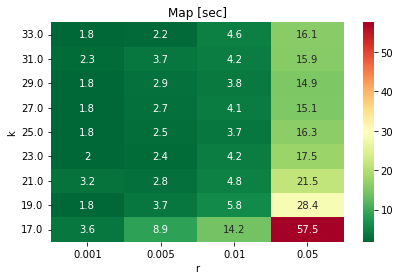

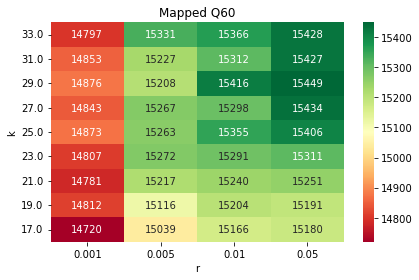

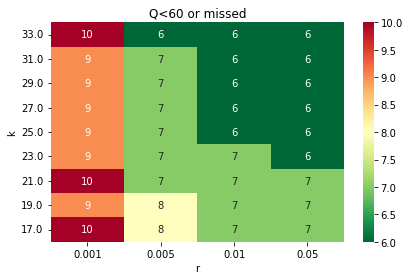

In [8]:
import re
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
np.set_printoptions(suppress=True)

def plot_heatmap(df_full, index, columns, values, name, cm):
    df = df_full.pivot(index=index, columns=columns, values=values)
    fig, ax = plt.subplots(figsize=(6, 4))
    fmt = 'd' if df.iloc[:, 0].dtype.kind == 'i' else '.4g'
    sns.heatmap(df, ax=ax, annot=True, cmap=cm, fmt=fmt) #, cbar=False)
    ax.set_title(values)
    ax.set_ylabel(df.index.name)
    ax.set_xlabel(df.columns.name)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    #fig.savefig(f'imgs/{name}.png', dpi=300)
    plt.close(fig)

def get_subdirs(eval_sketching_dir):
    return [full_dir.name for full_dir in eval_sketching_dir.glob('shmap-*')]

def auto_cast(value: str):
    try:
        return int(value)
    except ValueError:
        pass
    try:
        return float(value)
    except ValueError:
        pass
    return value

def parse_params(row):
    params = row.split('-')
    d = { param[0]: auto_cast(param[1:]) for param in params[1:] }
    return d

def add_params_to_columns(df):
    for row in df.index:
        params = parse_params(row)
        for key, value in params.items():
            df.loc[row, key] = value
    df['Q<60 or missed'] = df['Q<60 or missed'].str.rstrip('%').astype(float).astype(int)
    df['Wrong Q60'] = df['Wrong Q60'].astype(int)
    df['Index [sec]'] = df['Index [sec]'].astype(float)
    df['Map [sec]'] = df['Map [sec]'].astype(float)
    df['Memory [GB]'] = df['Memory [GB]'].astype(float)
    return df

def get_comparison_table_with_params(main_dir, experiment):
    shmap_tools = get_subdirs(main_dir)
    refname = experiment.split('-')[0]
    df = get_comparison_table(main_dir=main_dir, refname=refname, experiment=experiment, tools=shmap_tools).round(2)
    add_params_to_columns(df)
    return df

eval_sketching_dir = Path('out_small/sketching')
eval_experiment_str = 'chm13-chr1-readschm13-chr1-a?-d1-l?'
#eval_experiment_str = 'chm13-readshg002-a?-d0.1-l?'
df_all = get_comparison_table_with_params(main_dir=eval_sketching_dir, experiment=eval_experiment_str)

print(eval_experiment_str)
plot_heatmap(df_all, index='k', columns='r', values='Map [sec]', name='heatmapSM_maptime', cm='RdYlGn_r')
plot_heatmap(df_all, index='k', columns='r', values='Mapped Q60', name='heatmapSM_maptime', cm='RdYlGn')
plot_heatmap(df_all, index='k', columns='r', values='Q<60 or missed', name='heatmapSM_maptime', cm='RdYlGn_r')

In [17]:
def plot_line(df, x, y, ax):
    df.sort_values(by=x, inplace=True)
    df.plot(x=x, y=y, ax=ax, marker='o')
    #ax.set_title(y)
    ax.set_ylabel(y)
    ax.set_xlabel(x)

def plot_3lines(df, x, title):
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(6, 4), nrows=3, sharex=True)
    plot_line(df, x, 'Map [sec]', ax1)
    plot_line(df, x, 'Mapped Q60', ax2)
    plot_line(df, x, 'Q<60 or missed', ax3)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def get_line_df(df_full, base, var):
    base_params = parse_params(base)
    base_params.pop(var)
    df = df_full.copy()
    for key, value in base_params.items():
        df = df[df[key] == value]
    return df

def plot_line_params(main_dir, pivot, dataset, var):
    df_all = get_comparison_table_with_params(main_dir=main_dir, experiment=dataset)
    df = get_line_df(df_all, pivot, var)
    #display(df)
    plot_3lines(df, x=var, title='\n'.join([dataset, pivot]))


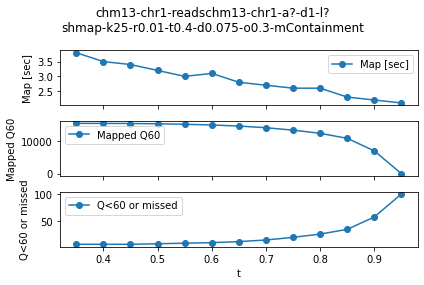

In [18]:
pivot = 'shmap-k25-r0.01-t0.4-d0.075-o0.3-mContainment'
dataset = 'chm13-chr1-readschm13-chr1-a?-d1-l?'
plot_line_params(Path('out_small/params'), pivot, dataset, 't')

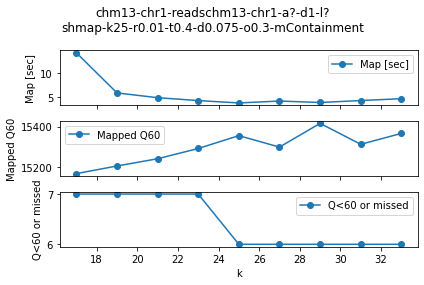

In [19]:
plot_line_params(Path('out_small/sketching'), pivot, dataset, 'k')

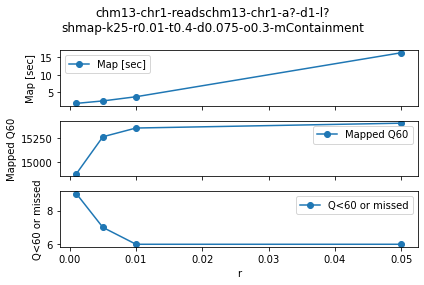

In [20]:
plot_line_params(Path('out_small/sketching'), pivot, dataset, 'r')

In [4]:
plot_line_params(Path('out_small/sketching'), 'chm13-readshg002-a?-d0.1-l?', 'r')

NameError: name 'plot_line_params' is not defined